In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from numba import *
import multiprocessing as mp

In [2]:
G = 10
L = 1
M = 1
MAX_SPEED = 8
dt = 0.05
MAX_TORQUE = 2

In [3]:
@njit
def getInitialState():
    angleRange = (-5 * np.pi / 6, 5 * np.pi / 6)
    angularVelocityRange = (-1,1)
    initialAngle = np.random.uniform(*angleRange)
    initialAngularVelocity = np.random.uniform(*angularVelocityRange)
    return (initialAngle, initialAngularVelocity)

In [4]:
@njit
def findNextState(angle, velocity, action):
    vel = (3 * G * np.sin(angle) / (2 * L)) + ((3 * action) / (M * (L * L)))
    newVelocity = max(min(velocity + (vel * 0.05), MAX_SPEED), -MAX_SPEED)
    newAngle = angle + (newVelocity * 0.05)
    return newAngle, newVelocity

In [5]:
@njit
def findReward(angle, velocity, action):
    w_normalized = ((angle + np.pi) % (2 * np.pi)) - np.pi
    reward = -1 * (np.square(w_normalized) + (0.1 * np.square(velocity)) + (0.001 * np.square(action)))
    return reward

In [6]:
@njit
def findRewardForEpisode(nn, initialState):
    angle, velocity = initialState
    reward = 0
    for t in range(200):
        state = np.array([angle, velocity], dtype=np.float64)
        action = nn.get_action(state)
        r_t = findReward(angle, velocity, action)
        reward += r_t
        newAngle, newVelocity = findNextState(angle, velocity, action)
        angle = newAngle
        velocity = newVelocity
    return reward
        

In [7]:
@njit
def estimateJ(nn, initialState):
    episodes = 10
    rewards = np.zeros(episodes)
    for ep in range(episodes):
        reward = findRewardForEpisode(nn, initialState)
        rewards[ep] = reward
    return np.average(rewards)

In [8]:
@njit
def startES(nn, initialState, sigma, alpha, nPerturbations, timeCount):
    weights = nn.get_weights()
    n = weights.shape[0]
    new_weights = np.random.randn(n)
    new_weights = new_weights.astype(np.float64)
    weights = new_weights
    rewards = np.zeros(timeCount, dtype=np.float64)
    policies = np.zeros((timeCount, n), dtype=np.float64)
    for tc in range(timeCount):
        nn.load_weights(weights)
        J_curr = estimateJ(nn, initialState)
        rewards[tc] = J_curr
        for i in range(n):
            policies[tc, i] = weights[i]
        sum_perturbations = np.zeros(n, dtype=np.float64)
        for _ in range(nPerturbations):
            epsilon_i = np.random.normal(loc=0, scale=1, size=n)
            perturbedWeight = weights + (sigma * epsilon_i)
            perturbedWeight = perturbedWeight.astype(np.float64)
            nn.load_weights(perturbedWeight)
            J_i = estimateJ(nn, initialState)
            for j in range(n):
                sum_perturbations[j] += (J_i - J_curr) * epsilon_i[j]
        new_policy = weights + (alpha * (sum_perturbations / (sigma * nPerturbations)))
        weights = new_policy.astype(np.float64)
    return rewards, policies

In [9]:
def run_single_algo(sigma, alpha, nPerturbations, nLayers, nNeurons, timeCount):
    nn = NeuralNetwork(np.int64(nLayers), np.array(nNeurons, dtype=np.int64))
    initialState = getInitialState()  # tuple consisting initial angle and angular velocity
    rewards, _ = startES(nn, initialState, sigma, alpha, nPerturbations, timeCount)
    return rewards

def startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount):
    rewards_per_timestep = np.zeros((nruns, timeCount), dtype=np.float64)  # Store rewards for each run and each time step
    pool = mp.Pool(processes=mp.cpu_count())
    tasks = [(sigma, alpha, nPerturbations, nLayers, nNeurons, timeCount) for _ in range(nruns)]
    results = pool.starmap(run_single_algo, tasks) 
    pool.close()
    pool.join()
    for run in range(nruns):
        rewards_per_timestep[run, :] = results[run]
    
    return rewards_per_timestep

In [10]:
@njit
def calculateStats(rewards):
    nruns, timeCount = rewards.shape
    avgReward = np.zeros(timeCount, dtype=np.float64)
    std_dev = np.zeros(timeCount, dtype=np.float64)
    for t in range(timeCount):
        sum_rewards = 0.0
        for run in range(nruns):
            sum_rewards += rewards[run, t]
        avgReward[t] = sum_rewards / nruns
    for t in range(timeCount):
        sum_squares = 0.0
        for run in range(nruns):
            sum_squares += (rewards[run, t] - avgReward[t]) ** 2
        std_dev[t] = np.sqrt(sum_squares / nruns)

    return avgReward, std_dev

In [11]:
def plotTable(avgReward, std_dev, timeCount):
    time_steps = np.arange(timeCount)
    table_data = np.column_stack((time_steps, avgReward, std_dev))
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=table_data, colLabels=['Iteration', 'Mean (Avg Reward)', 'Std Dev'],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    plt.show()

In [46]:
def plotGraph(avgReward, std_dev, timeCount, showValues, params):
    time_steps = np.arange(timeCount)
    plt.plot(time_steps, avgReward, label='Average Reward', color='yellow', linestyle='-', linewidth=1)
    plt.fill_between(time_steps, avgReward - std_dev, avgReward + std_dev, color='blue', alpha=0.2, label='Std Dev across Mean')
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount = params
    nNeurons_str = ', '.join(map(str, nNeurons))
    plt.suptitle('Average Reward and Standard Deviation per Iteration', fontsize=12)
    plt.figtext(0.5, 0.93, f'\nSigma: {sigma}, Alpha: {alpha}, nPerturbations: {nPerturbations}, '
                           f'Hidden Layers: {nLayers}, Neurons: [{nNeurons_str}], Runs: {nruns}, Iterations: {timeCount}',
                ha='center', fontsize=8)
    plt.grid(True)
    plt.legend()
    plt.xticks(np.arange(0, timeCount + 1, 50))
    y_min = min(avgReward - std_dev)
    y_max = max(avgReward + std_dev)
    y_min_rounded = np.floor(y_min / 200) * 200
    y_max_rounded = np.ceil(y_max / 200) * 200
    plt.ylim(y_min_rounded, y_max_rounded)
    plt.yticks(np.arange(y_min_rounded, y_max_rounded + 1, 200))
    plt.show()
    if showValues:
        plotTable(avgReward, std_dev, timeCount)


In [13]:
# sigma = 0.1
# alpha = 0.001
# nPerturbations = 100
# nLayers = 2
# nNeurons = [3,3]
# nruns = 5
# timeCount = 100
# showValues = False
# rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
# avgReward, std_dev = calculateStats(rewards)
# params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
# plotGraph(avgReward, std_dev, timeCount, showValues, params)
# print(f"Average Reward after {nruns} run: {avgReward[-1]}")
# print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

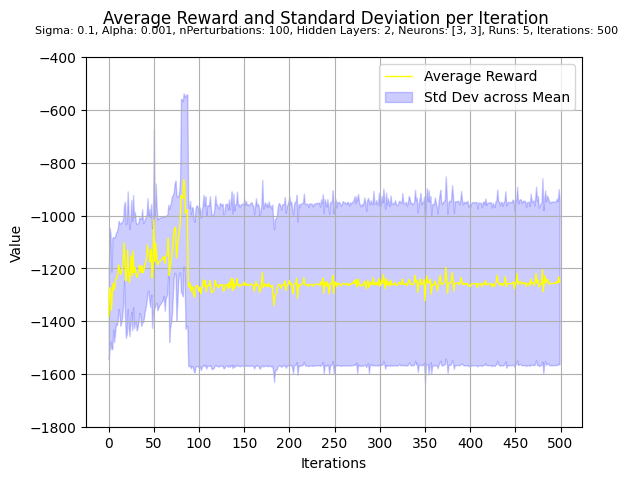

Average Reward after 5 run: -1252.5981090851524
Standard Deviation after 5 run: 310.1262878951568


In [14]:
sigma = 0.1
alpha = 0.001
nPerturbations = 100
nLayers = 2
nNeurons = [3,3]
nruns = 5
timeCount = 500
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

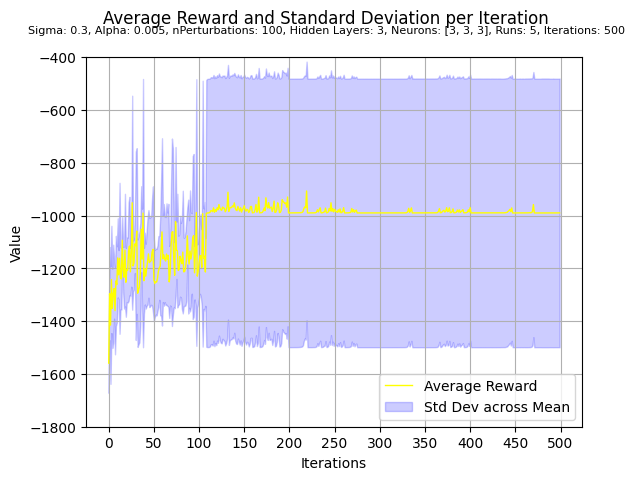

Average Reward after 5 run: -990.0463740477093
Standard Deviation after 5 run: 508.99943697430587


In [15]:
sigma = 0.3
alpha = 0.005
nPerturbations = 100
nLayers = 3
nNeurons = [3,3,3]
nruns = 5
timeCount = 500
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

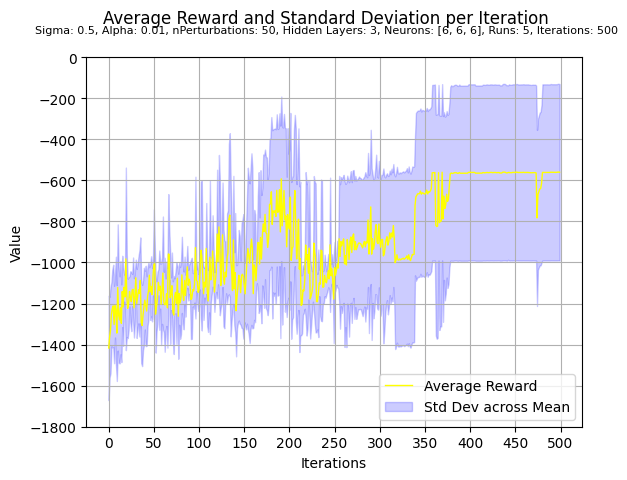

Average Reward after 5 run: -560.8858656496911
Standard Deviation after 5 run: 429.4913924531917


In [16]:
sigma = 0.5
alpha = 0.01
nPerturbations = 50
nLayers = 3
nNeurons = [6,6,6]
nruns = 5
timeCount = 500
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

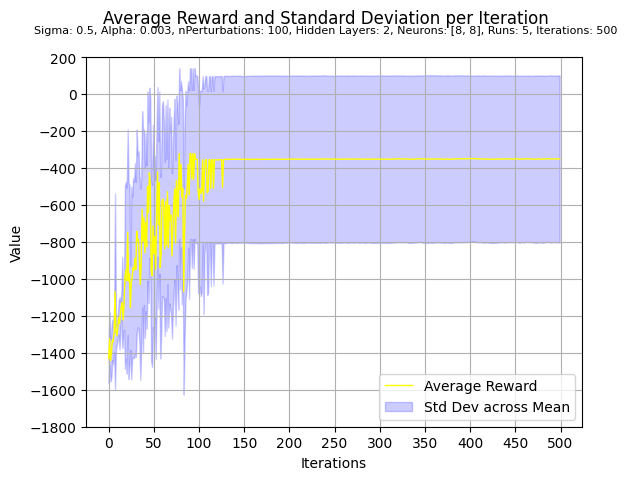

Average Reward after 5 run: -351.03057856780396
Standard Deviation after 5 run: 451.6479657921492


In [17]:
sigma = 0.5
alpha = 0.003
nPerturbations = 100
nLayers = 2
nNeurons = [8,8]
nruns = 5
timeCount = 500
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

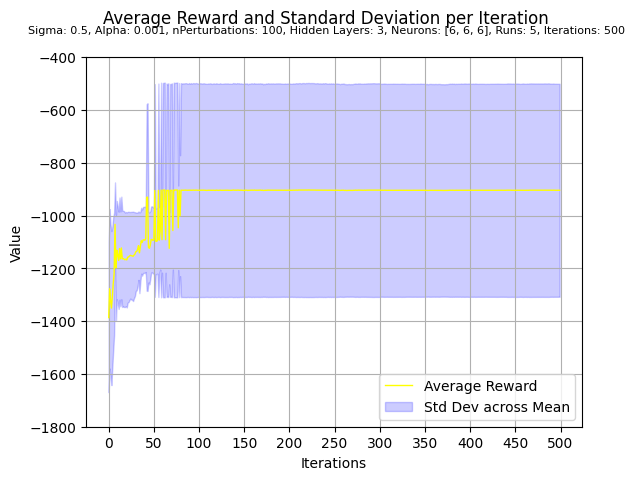

Average Reward after 5 run: -904.3112535724653
Standard Deviation after 5 run: 403.38938876063554


In [18]:
sigma = 0.5
alpha = 0.001
nPerturbations = 100
nLayers = 3
nNeurons = [6, 6, 6]
nruns = 5
timeCount = 500
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

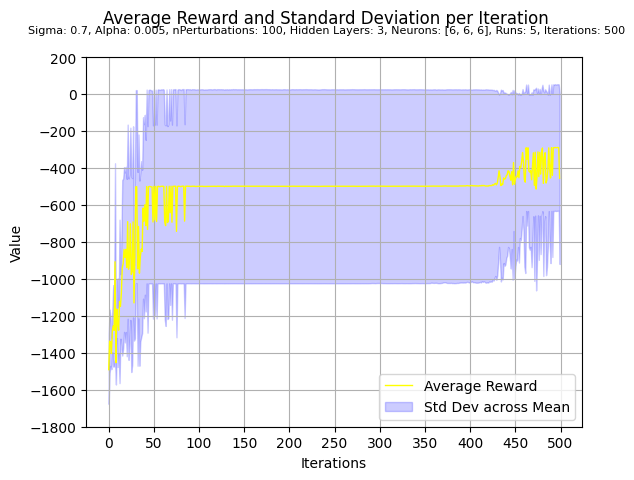

Average Reward after 5 run: -455.79468304654466
Standard Deviation after 5 run: 463.3986046202444


In [19]:
sigma = 0.7
alpha = 0.005
nPerturbations = 100
nLayers = 3
nNeurons = [6, 6, 6]
nruns = 5
timeCount = 500
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

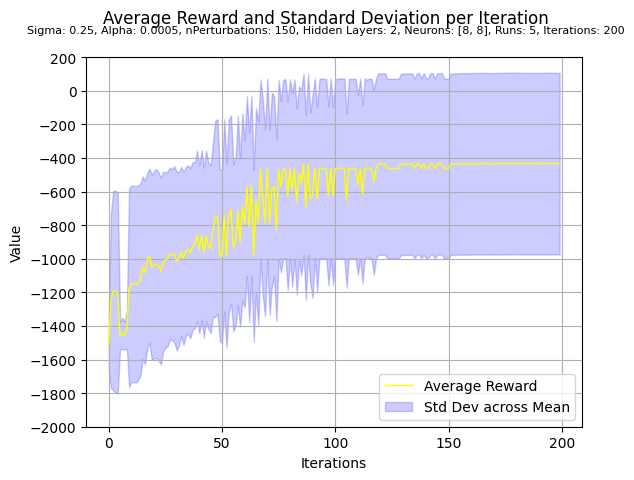

Average Reward after 5 run: -433.858167381455
Standard Deviation after 5 run: 540.8124490434205


In [20]:
sigma = 0.25
alpha = 0.0005
nPerturbations = 150
nLayers = 2
nNeurons = [8,8]
nruns = 5
timeCount = 200
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

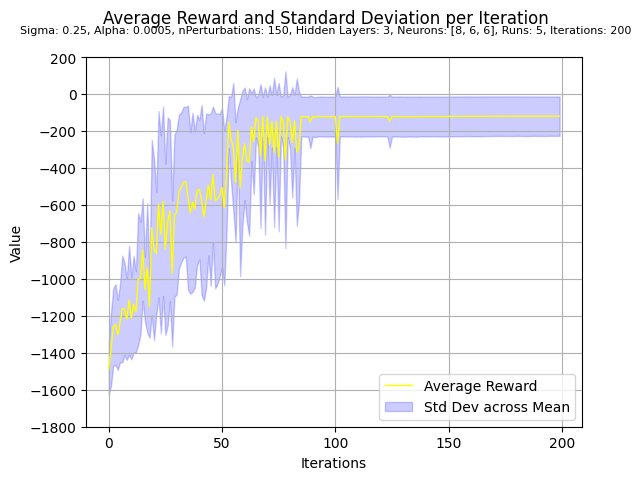

Average Reward after 5 run: -119.57069798223895
Standard Deviation after 5 run: 106.49773611850665


In [38]:
sigma = 0.25
alpha = 0.0005
nPerturbations = 150
nLayers = 3
nNeurons = [8,6,6]
nruns = 5
timeCount = 200
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

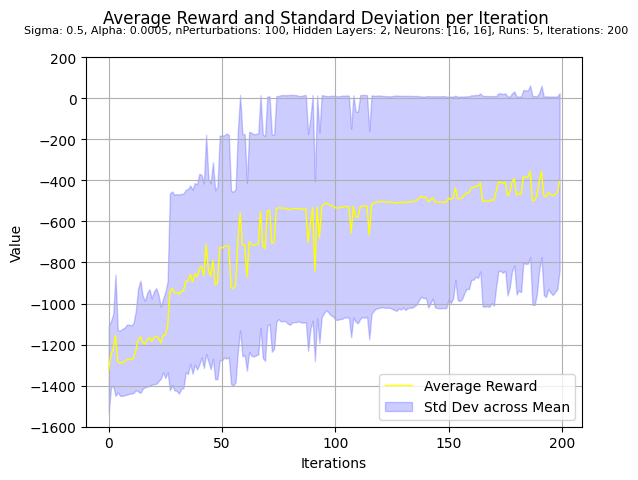

Average Reward after 5 run: -406.65779562438615
Standard Deviation after 5 run: 430.7710046755951


In [29]:
sigma = 0.5
alpha = 0.0005
nPerturbations = 100
nLayers = 2
nNeurons = [16,16]
nruns = 5
timeCount = 200
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

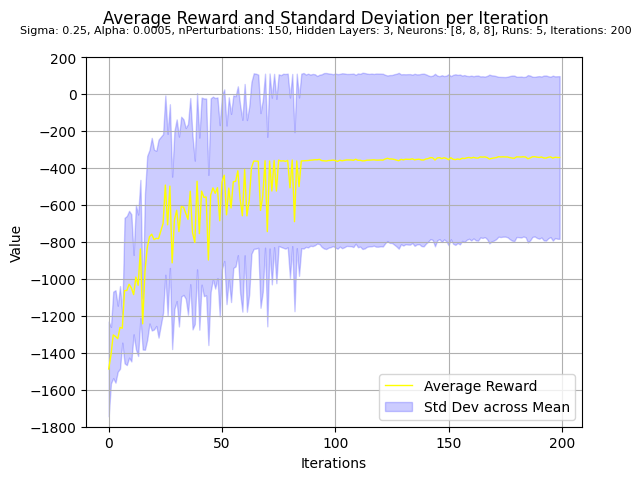

Average Reward after 5 run: -343.1982971054835
Standard Deviation after 5 run: 440.39290280037164


In [39]:
sigma = 0.25
alpha = 0.0005
nPerturbations = 150
nLayers = 3
nNeurons = [8,8,8]
nruns = 5
timeCount = 200
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

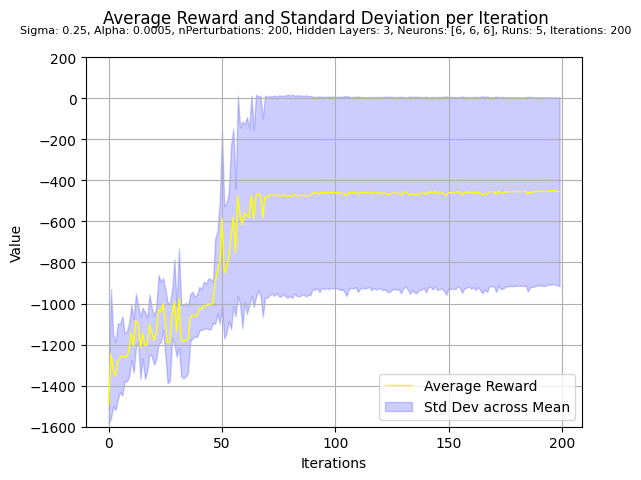

Average Reward after 5 run: -455.0734003362906
Standard Deviation after 5 run: 459.77854576880685


In [40]:
sigma = 0.25
alpha = 0.0005
nPerturbations = 200
nLayers = 3
nNeurons = [6,6,6]
nruns = 5
timeCount = 200
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")

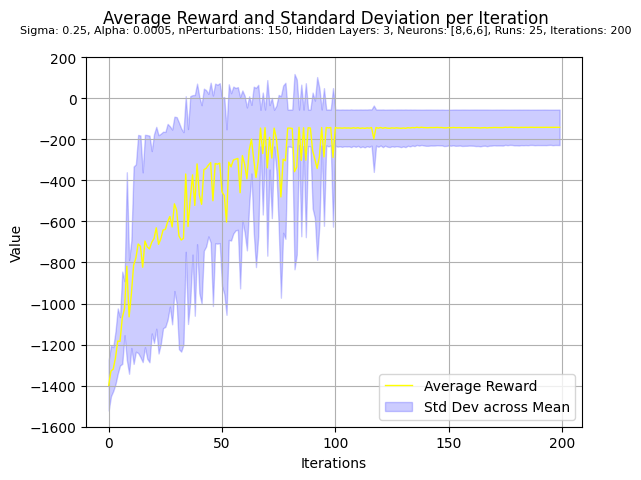

Average Reward after 25 run: -141.957442041462
Standard Deviation after 25 run: 86.41030232637438


In [53]:
sigma = 0.25
alpha = 0.0005
nPerturbations = 150
nLayers = 3
nNeurons = [8,6,6]
nruns = 25
timeCount = 200
showValues = False
rewards = startAlgo(sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount)
avgReward, std_dev = calculateStats(rewards)
params = [sigma, alpha, nPerturbations, nLayers, nNeurons, nruns, timeCount]
plotGraph(avgReward, std_dev, timeCount, showValues, params)
print(f"Average Reward after {nruns} run: {avgReward[-1]}")
print(f"Standard Deviation after {nruns} run: {std_dev[-1]}")